In [105]:
import pandas as pd
import csv

import matplotlib.pyplot as plt
import seaborn as sns

import time
import math
import re
from textblob import TextBlob

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.utils import simple_preprocess
pyLDAvis.enable_notebook()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [5]:
# this data was obtained in a previous course: Data Mining with Utku Winter 2023
# used this dataset: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset
# scraped lyrics for these songs using Lyric Genius API
songs_lyrics = pd.read_csv('Data/ML_lyrics_genre.csv')

In [ ]:
# Huge dataset: https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information 

# cleaned: https://data.mendeley.com/datasets/3t9vbwxgr5/2

In [6]:
songs_lyrics = songs_lyrics.drop_duplicates(subset=["track_name", "artists"])

In [7]:
songs_lyrics[songs_lyrics.track_genre=='acoustic']

,Unnamed: 0,track_name,artists,lyrics,Song_id,url,release_date,track_genre
0,0,To Begin Again,Ingrid Michaelson;ZAYN,TranslationsNorsk (bokmål / riksmål)EspañolBos...,6597928.0,https://genius.com/Ingrid-michaelson-and-zayn-...,"March 17, 2021",acoustic
1,1,Can't Help Falling In Love,Kina Grannis,Can’t Help Falling in Love Lyrics[Verse 1]\nWi...,3890906.0,https://genius.com/Kina-grannis-cant-help-fall...,"January 13, 2017",acoustic
3,3,Hold On,Chord Overstreet,Hold On Lyrics[Verse 1]\nLoving and fighting\n...,2973448.0,https://genius.com/Chord-overstreet-hold-on-ly...,"February 2, 2017",acoustic
5,5,Days I Will Remember,Tyrone Wells,Days I will Remember LyricsThese are the days ...,3805340.0,https://genius.com/Tyrone-wells-days-i-will-re...,"April 20, 2018",acoustic
8,8,Say Something,A Great Big World;Christina Aguilera,TranslationsPortuguêsSay Something Lyrics[Intr...,255826.0,https://genius.com/A-great-big-world-say-somet...,"November 4, 2013",acoustic
...,...,...,...,...,...,...,...,...
1275,1275,Fast Track,Days N Daze,Fast Track LyricsLet’s fast track\nThrough the...,5336984.0,https://genius.com/Days-n-daze-fast-track-lyrics,"May 1, 2020",acoustic
1276,1276,Maria,Harley Poe,"Maria Lyrics[Verse 1]\nSweet Jesus, please hel...",3660031.0,https://genius.com/Harley-poe-maria-lyrics,"May 10, 2010",acoustic
1277,1277,Tall Cans,Pigeon Pit,Tall Cans LyricsI’m trying to stay awake ridin...,3618854.0,https://genius.com/Pigeon-pit-tall-cans-lyrics,"April 26, 2017",acoustic
1278,1278,You Get What You Give,Chuck Ragan,You Get What You Give LyricsWell I shake when ...,1244669.0,https://genius.com/Chuck-ragan-you-get-what-yo...,"September 13, 2011",acoustic


In [8]:
list(songs_lyrics.lyrics)[1]

"Can’t Help Falling in Love Lyrics[Verse 1]\nWise men say\nOnly fools rush in\nBut I can't help falling in love with you\n\n[Verse 2]\nShall I stay?\nWould it be a sin?\nIf I can't help falling in love with you\n\n[Chorus]\nLike a river flows\nSurely to the sea\nDarling, so it goes\nSome things are meant to be\n[Verse 3]\nSo take my hand\nTake my whole life, too\nFor I can't help falling in love with you\nFor I can't help falling in love with youYou might also like1Embed"

In [9]:
len(songs_lyrics)

35015

In [10]:
songs_lyrics.track_genre.unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

In [12]:
songs_trimmed = songs_lyrics[songs_lyrics.track_genre.isin(['alt-rock','alternative','country','edm','emo','funk','gospel','goth','grunge',\
                                                            'hard-rock','heavy-metal','hip-hop','indie','indie-pop','metal','party','pop',\
                                                            'punk-rock','punk','reggae','rock-n-roll','rock'])]




In [16]:
songs_trimmed_nodups = songs_trimmed.drop_duplicates(subset=['track_name','artists'])

In [17]:
songs_trimmed.track_genre.value_counts()

grunge         686
emo            545
country        516
goth           493
alt-rock       472
edm            404
hard-rock      336
indie-pop      316
hip-hop        244
alternative    204
rock-n-roll    196
metal          167
punk-rock      162
rock           148
heavy-metal    138
funk           133
pop            128
punk            78
reggae          46
indie           42
party           40
gospel          32
Name: track_genre, dtype: int64

## Clean Huge Df

In [2]:
from google.cloud import storage
import os
import io
client = storage.Client()
bucket = client.get_bucket('nlp_final_data')

In [3]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

workers = num_processors-1

Available CPUs: 16


In [4]:
#! pip install pandarallel
import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:

blob = bucket.blob('song_lyrics.csv')
content = blob.download_as_string()

songs = pd.read_csv(io.BytesIO(content))

In [6]:
songs.columns

Index(['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'id',
       'language_cld3', 'language_ft', 'language'],
      dtype='object')

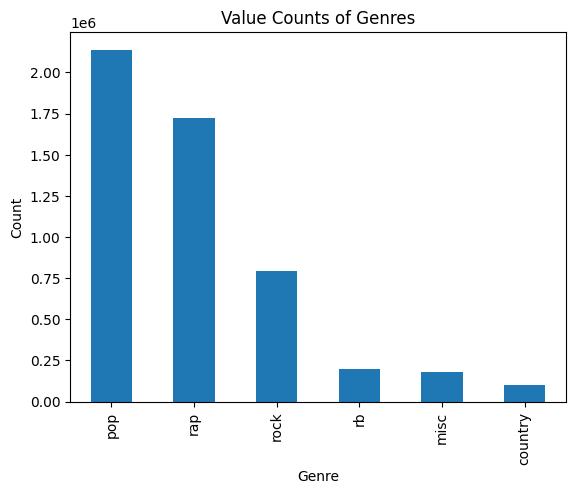

In [7]:
# Plot value counts as a bar plot
songs['tag'].value_counts().plot(kind='bar')

# Set plot title and axis labels
plt.title('Value Counts of Genres')
plt.xlabel('Genre')
plt.ylabel('Count')

# Display the plot
plt.show()

In [8]:
len(songs)

5134856

## Get rid of Duplicates

In [9]:
songs_new = songs.drop_duplicates(subset = ['title','artist'])

In [10]:
len(songs_new)

5134845

## Get Only English Songs

In [11]:
songs_eng = songs_new[songs_new.language=='en']

In [12]:
len(songs_eng)

3374188

## Get Rid of Misc Genre

In [13]:
songs_noMIsc = songs_eng[songs_eng.tag!='misc']

In [14]:
len(songs_noMIsc)

3233202

## Look at artists

In [29]:
songs_noMIsc.artist.value_counts()[:20]

Genius English Translations    13591
The Grateful Dead               2108
Lil B                           1306
Gucci Mane                      1239
Frank Zappa                     1232
Lil Wayne                       1208
KIDZ BOP Kids                   1199
Guided by Voices                1188
Tendon Levey                    1183
Juice WRLD                      1167
Frank Sinatra                   1068
Johnny Cash                     1041
Muze Sikk                        967
Madonna                          958
Willie Nelson                    951
Chief Keef                       924
OCTOBERSFULLMOON                 922
YOUNG DIAMOND                    896
Bob Dylan                        881
The Rolling Stones               855
Name: artist, dtype: int64

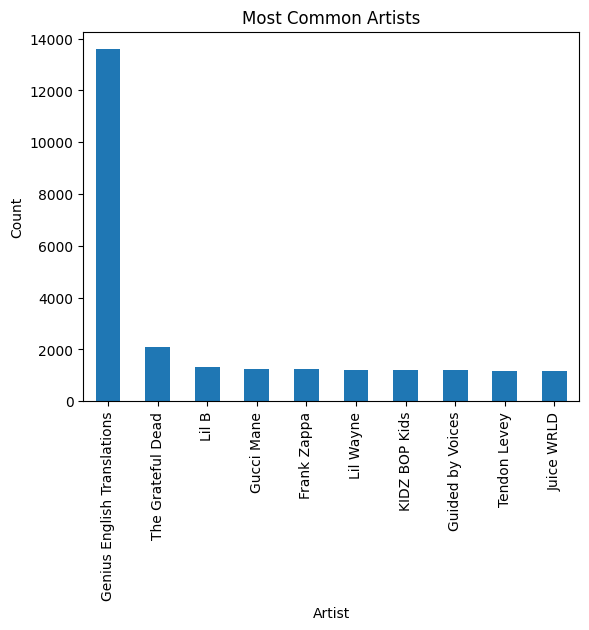

In [33]:
# Plot value counts as a bar plot
songs_noMIsc.artist.value_counts()[:10].plot(kind='bar')

# Set plot title and axis labels
plt.title('Most Common Artists')
plt.xlabel('Artist')
plt.ylabel('Count')

# Display the plot
plt.show()

In [26]:
songs_noMIsc[songs_noMIsc.artist=='Gucci Mane']

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
28,Colors,rap,Gucci Mane,2008,34914,{},[Verse 1]\nBlue and white Charger\nSame color ...,21,en,en,en
314,Lemonade,rap,Gucci Mane,2009,448340,{},"[Intro: Gucci Mane]\nYeah, it's Gucci, what's ...",293,en,en,en
360,Bingo,rap,Gucci Mane,2010,16293,"{""Waka Flocka Flame"",""Soulja Boy""}","[Intro: Gucci Mane, Soulja Boy & Waka Flocka F...",356,en,en,en
361,Volume,rap,Gucci Mane,2009,9414,"{""Wooh da Kid""}",[Hook]\nI'm so motherfuckin' turned up right n...,357,en,en,en
364,Gingerbread Man,rap,Gucci Mane,2009,7198,"{""OJ da Juiceman""}",[Verse 1: Gucci Mane]\nI'mma keep dropping ver...,360,en,en,en
...,...,...,...,...,...,...,...,...,...,...,...
4916544,Nose Red,rap,Gucci Mane,2021,650,{},"[Intro]\nDamn (J. White, I need a beat I can g...",7498003,en,en,en
4950743,Fake Friends,rap,Gucci Mane,2022,1389,{},"[Intro]\nYou know it's family first off top, a...",7555786,en,en,en
4994773,Rumors,rap,Gucci Mane,2022,81426,"{""Lil Durk""}","[Intro]\n(Tay Keith, fuck these niggas up)\n(D...",7630490,en,en,en
5071280,Publicity Stunt,rap,Gucci Mane,2022,52077,{},[Intro: Pooh Shiesty]\n1017 (Blrrrd)\n\n[Choru...,7764006,en,en,en


## Get rid of Kidz Bop Kids and Genius English Translations because they are not individual artists

In [30]:
songs_new = songs_noMIsc[songs_noMIsc.artist!='Genius English Translations']

In [31]:
songs_new = songs_new[songs_new.artist!='KIDZ BOP Kids ']

## Also get rid of artists that appear less than 20 times, since they are likely not real artists and have 'joke' songs

In [40]:
counts = songs_new['artist'].value_counts()

In [54]:
mask = songs_new['artist'].isin(counts[counts > 20].index)

In [55]:
songs_filtered = songs_new[mask]

In [56]:
songs_filtered.artist.value_counts()[-10:]

HEARTBREAKHOTEL    21
Anna Burch         21
Zack Banton        21
L Jitt             21
Marvelous Liars    21
Butch Dawson       21
tiLLie             21
P1LOT              21
BlueBand TrE       21
Ruggedman          21
Name: artist, dtype: int64

## Get rid of songs that are not listened to very often

In [66]:
songs_filtered.views.describe()

count    1.909850e+06
mean     5.342698e+03
std      6.951701e+04
min      0.000000e+00
25%      4.200000e+01
50%      1.840000e+02
75%      8.590000e+02
max      1.757563e+07
Name: views, dtype: float64

In [69]:
songs_filtered[songs_filtered.views<20]

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
16871,Dont Get it Curled,rap,Dom Pachino,2006,19,{},"[Intro: Dom Pachino]\nYeah, take a walk with m...",17671,en,en,en
43293,Blunted Freestyle 4,rap,The Tongue,2011,9,{},Bringing it back today like it was back in the...,45760,en,en,en
46794,The World Is Yours Remix,rap,Prezidential Candidates,2010,17,{},"[Verse 1: Prez]\nAyo, catch me on the corner w...",49591,en,en,en
47285,Never Fall,rap,Prezidential Candidates,2011,16,{},[Hook: Marka]\n\n[Verse 1: Nasty Boi]\nSuccess...,49761,en,en,en
47294,What I Am,rap,Prezidential Candidates,2010,12,{},[Hook: Nasty Boi]\nI've been dealin' wit your ...,49769,en,en,en
...,...,...,...,...,...,...,...,...,...,...,...
5134828,Cut Corners,pop,Ryan Egan,2022,3,{},Some people say I’ve been wrong\nLost my head ...,7882812,en,en,en
5134835,Now Were Cookin,pop,Son Lux,2022,2,"{""Randy Newman""}",It's really not that crazy (we're not that cra...,7882822,en,en,en
5134837,Dont Say You Never Loved Me,pop,Ryan Egan,2022,3,{},Since I saw the message from you\nI’m seeing g...,7882824,en,en,en
5134844,Baby Hold On,pop,Ryan Egan,2022,5,{},At this crossroads\nI don’t wanna go and gambl...,7882831,en,en,en


In [81]:
songs_filtered = songs_filtered[songs_filtered.views>42]

## Check the distribution of genres now that we have removed a lot of songs

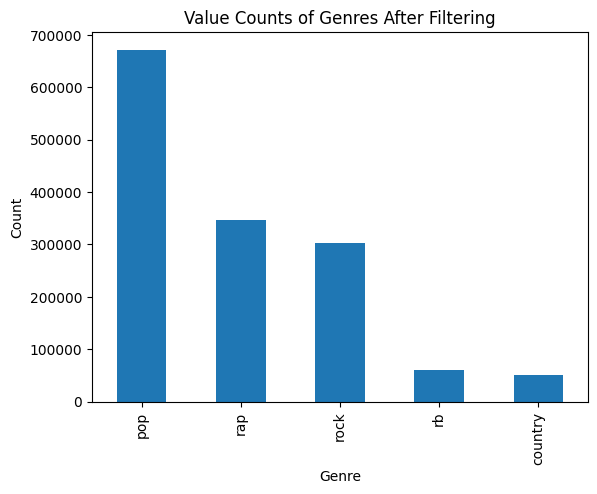

In [82]:
# Plot value counts as a bar plot
songs_filtered['tag'].value_counts().plot(kind='bar')

# Set plot title and axis labels
plt.title('Value Counts of Genres After Filtering')
plt.xlabel('Genre')
plt.ylabel('Count')

# Display the plot
plt.show()

In [83]:
songs_filtered['tag'].value_counts()

pop        671649
rap        346573
rock       302248
rb          60218
country     51332
Name: tag, dtype: int64

## only use the top 50,000 most listened to songs for each genre

In [95]:
songs_pop = songs_filtered[songs_filtered.tag=='pop'].sort_values(by=['views'],ascending=False)
songs_rap = songs_filtered[songs_filtered.tag=='rap'].sort_values(by=['views'],ascending=False)
songs_rock = songs_filtered[songs_filtered.tag=='rock'].sort_values(by=['views'],ascending=False)
songs_rb = songs_filtered[songs_filtered.tag=='rb'].sort_values(by=['views'],ascending=False)
songs_country = songs_filtered[songs_filtered.tag=='country'].sort_values(by=['views'],ascending=False)

In [96]:
top_songs = pd.concat([songs_pop.head(50000),songs_rap.head(50000),songs_rock.head(50000),songs_rb.head(50000),songs_country.head(50000)], axis=0)

In [97]:
top_songs

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
1950930,Shape of You,pop,Ed Sheeran,2017,14569727,{},[Verse 1]\nThe club isn't the best place to fi...,2949128,en,en,en
2703693,​thank u next,pop,Ariana Grande,2018,9072131,{},[Verse 1]\nThought I'd end up with Sean\nBut h...,4063065,en,en,en
1752512,Work,pop,Rihanna,2016,7871555,{Drake},"[Chorus: Rihanna]\nWork, work, work, work, wor...",2398213,en,en,en
2153176,Too Good at Goodbyes,pop,Sam Smith,2017,7784454,{},[Verse 1]\nYou must think that I'm stupid\nYou...,3219597,en,en,en
2706746,7 rings,pop,Ariana Grande,2019,7387794,{},"[Verse 1]\nYeah, breakfast at Tiffany's and bo...",4067762,en,en,en
...,...,...,...,...,...,...,...,...,...,...,...
3614037,Georgia On My Mind,country,Tony Rice,1975,50,{},"Georgia, Georgia, the whole day through\nAn' j...",5462856,en,en,en
1100406,Please Help Me I’m Falling,country,Wanda Jackson,1964,50,{},"Please help me, I'm falling in love with you\n...",1431420,en,en,en
2392434,18 Reasons,country,Johnathan East Band,2010,50,{},Struck out this morning flying down the 501\nH...,3610692,en,en,en
384308,Standing Room Only,country,Kitty Wells,1956,50,{},In your heart there's just standing room only\...,586716,en,en,en


In [98]:
top_songs.to_csv('top_songs.csv')

## Clean and Tokenize the text

In [100]:
import re
top_songs['lyrics_cleaned'] = top_songs['lyrics'].apply(lambda x: re.sub(r'\[[^\]]*\]', '', x))
top_songs['lyrics_cleaned'] = top_songs['lyrics_cleaned'].apply(lambda x: re.sub(r'\n', ' ', x))

In [103]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_list = top_songs['lyrics_cleaned'].tolist()

CPU times: user 12.7 ms, sys: 162 µs, total: 12.8 ms
Wall time: 11.8 ms


In [106]:
data_tokens = list(sent_to_words(data_list))

In [112]:
%%time
import spacy

stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

2023-05-23 09:57:00.369790: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-23 09:57:00.369845: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-23 09:57:00.369875: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nlpfinal): /proc/driver/nvidia/version does not exist


CPU times: user 6.5 s, sys: 784 ms, total: 7.28 s
Wall time: 13 s


In [109]:
# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

In [113]:
data_lemmatized = lemmatization(data_tokens_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [114]:
top_songs['data_tokenized'] = data_lemmatized

In [115]:
top_songs.to_csv('top_songs_tokens.csv')

## Check Song Lengths and get rid of songs that are too long or too short

In [126]:
top_songs['num_tokens'] = top_songs['data_tokenized'].apply(lambda x: len(x))

In [127]:
top_songs.sort_values(by=['num_tokens'])

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language,lyrics_cleaned,data_tokenized,num_tokens
1650075,Nangs,rock,Tame Impala,2015,123859,{},[Interlude]\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut is there something more than that?\nBut...,2165812,en,en,en,But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more than that? But is there something more...,[],0
216670,Over,rock,A Perfect Circle,2000,5552,{},Been over\nBeen over this before\nBeen over and over\nBeen over this before\n\nAnd over\nBeen over this before\n\nSo over this\nBeen over this\nSo over this\nBeen over this\nOver this before,253848,en,en,en,Been over Been over this before Been over and over Been over this before And over Been over this before So over this Been over this So over this Been over this Over this before,[],0
2297077,​xx,pop,Hayley Kiyoko,2018,17636,{},"[Intro]\nYeah, yeah\nYeah, yeah\nWhy'd you do that?\nYeah, yeah\nYeah, yeah\nWhy'd you do that?\nYeah, yeah\nYeah, yeah\nWhy'd you do that?\nYeah, yeah\nYeah, yeah\nWhy'd you do that?\nYeah, yeah\nYeah, yeah\nYeah, yeah\nYeah, yeah\nWhy'd you do that?",3444425,en,en,en,"Yeah, yeah Yeah, yeah Why'd you do that? Yeah, yeah Yeah, yeah Why'd you do that? Yeah, yeah Yeah, yeah Why'd you do that? Yeah, yeah Yeah, yeah Why'd you do that? Yeah, yeah Yeah, yeah Yeah, yeah Yeah, yeah Why'd you do that?",[],0
2199622,Backwater,rb,Kllo,2017,911,{},"No, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now\nNo, I don't, everything's over now",3281892,en,en,en,"No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now No, I don't, everything's over now",[],0
469192,Marvin Interlude,rb,Mary J. Blige,1994,1020,{},"[Verse]\nOh, oh, you know that I\nYou know that I want to be with you, with you\nI just wanna be with you\nOh, oh, ooh, oh, oh, oh, oh, oh, oh, oh",765778,en,en,en,"Oh, oh, you know that I You know that I want to be with you, with you I just wanna be with you Oh, oh, ooh, oh, oh, oh, oh, oh, oh, oh",[want],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4555690,Rolling 110 Deep,rap,DJ Kay Slay,2021,53438,"{""Ghostface Killah"",Twista,""Styles P"",Raekwon,""Jim Jones"",AZ,""Black Thought"",""Sauce Money"",""Big Daddy Kane"",Redman,Cassidy,""Sheek Louch"",""Joell Ortiz"",""Bun B"",""J.R. Writer"",Consequence,""Cory Gunz"",""MC Shan"",""Young Buck"",""KXNG Crooked"",""Uncle Murda"",""Inspectah Deck"",McGruff,""Loaded Lux"",Saigon,Locksmith,Vado,""Stan Spit"",""K

In [131]:
top_songs.num_tokens.quantile(.05)

40.0

In [136]:
top_songs.num_tokens.quantile(.98)

335.0

In [137]:
top_songs_final = top_songs[(top_songs.num_tokens<335) & (top_songs.num_tokens>40)]

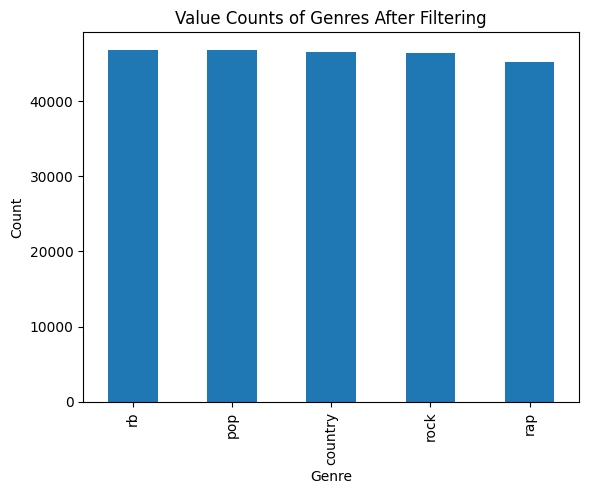

In [138]:
# Plot value counts as a bar plot
top_songs_final['tag'].value_counts().plot(kind='bar')

# Set plot title and axis labels
plt.title('Value Counts of Genres After Filtering')
plt.xlabel('Genre')b
plt.ylabel('Count')

# Display the plot
plt.show()

In [139]:
top_songs_final.to_csv('top_songs_final.csv')

In [2]:
from google.cloud import storage
import os
import io
client = storage.Client()
bucket = client.get_bucket('nlp_final_data')

blob = bucket.blob('songs_nGrams.csv')

In [3]:
blob = bucket.blob('top_songs_final.csv')
blob.upload_from_filename('top_songs_final.csv')

## Create Model

In [140]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM,Dense,Dropout, Reshape, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.models import Sequential
from keras.layers import Embedding,SimpleRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

from tensorflow.keras.optimizers import Adam

from gensim.models import Word2Vec

In [141]:
X = top_songs_final['data_tokenized']
y = top_songs_final['tag']

In [142]:
# split the balanced data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2,stratify=y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [143]:
tokenize = Tokenizer(char_level=False)
tokenize.fit_on_texts(X) # only fit on train

# we will need this later
num_words = len(tokenize.word_index)+1

In [144]:
num_words

106895

In [145]:
x_train = tokenize.texts_to_sequences(X_train)
x_test = tokenize.texts_to_sequences(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [146]:
max_len = 0
for song in x_train:
    if len(song)>max_len:
        max_len = len(song)

In [147]:
max_log_length = max_len
x_train = pad_sequences(x_train, maxlen=max_log_length)
x_test = pad_sequences(x_test, maxlen=max_log_length)

In [162]:
model3 = Sequential()

model3.add(Embedding(input_dim=num_words,output_dim=64,input_length=max_log_length))

num_filters = 128
kernel_sizes = [2,3]
for kernel_size in kernel_sizes:
    model3.add(Conv1D(num_filters, kernel_size, activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
#model3.add(Conv1D(128, 3, activation='relu'))


model3.add(LSTM(units=64,recurrent_dropout=0.5))
model3.add(Dropout(0.5))

# Add Dense layers
hidden_units = [128,64]
for units in hidden_units:
    model3.add(Dense(units, activation='relu'))
    model3.add(Dropout(0.5))
    
model3.add(Dense(num_classes,activation='softmax'))

# compile the model
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [152]:
history = model3.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/10
1305/1305 [==============================] - 218s 165ms/step - loss: 1.2153 - accuracy: 0.4757 - val_loss: 1.0410 - val_accuracy: 0.5731
Epoch 2/10
1305/1305 [==============================] - 210s 161ms/step - loss: 1.0215 - accuracy: 0.5952 - val_loss: 1.0017 - val_accuracy: 0.5974
Epoch 3/10
1305/1305 [==============================] - 210s 161ms/step - loss: 0.9312 - accuracy: 0.6364 - val_loss: 1.0199 - val_accuracy: 0.5958
Epoch 4/10
1305/1305 [==============================] - 209s 160ms/step - loss: 0.8506 - accuracy: 0.6743 - val_loss: 1.0558 - val_accuracy: 0.5804
Epoch 5/10
1305/1305 [==============================] - 207s 159ms/step - loss: 0.7672 - accuracy: 0.7116 - val_loss: 1.1595 - val_accuracy: 0.5813
Epoch 6/10
1305/1305 [==============================] - 208s 160ms/step - loss: 0.6788 - accuracy: 0.7489 - val_loss: 1.2094 - val_accuracy: 0.5776
Epoch 7/10
1305/1305 [==============================] - 208s 159ms/step - loss: 0.5955 - accuracy: 0.7829 - val_

In [150]:
model3.save('model_top_songs.h5')

In [158]:
def plot_train(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    epochs = range(1, len(h['accuracy']) + 1)
    plt.plot(epochs, h['accuracy'], 'go', label='Training acc')
    plt.plot(epochs, h['val_accuracy'], 'g', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

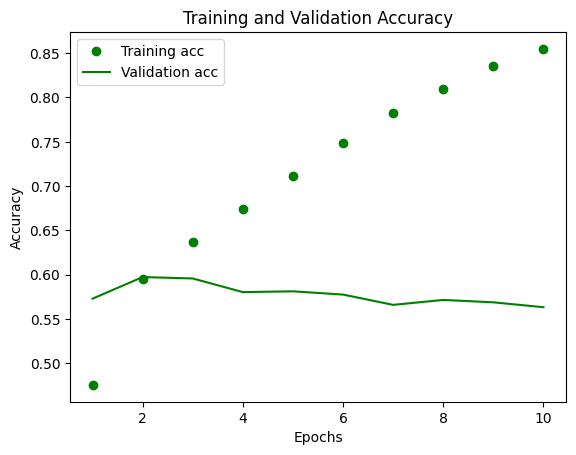

In [159]:
plot_train(history)

In [63]:
bucket_name = 'nlp_final_data'

def write_to_blob(bucket_name,filename,data):
    with open(data, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)

    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(filename)
    blob.upload_from_filename(filename)

In [78]:
write_to_blob(bucket_name,'songs_filtered.csv',songs_filtered)

TypeError: expected str, bytes or os.PathLike object, not DataFrame

In [23]:
songs_noMIsc.tag.value_counts()

pop        1393559
rap         964605
rock        633308
rb          155082
country      86658
Name: tag, dtype: int64

In [27]:
len(sampled_df)

433290

In [35]:
sampled_df.to_csv('songs_even_sample.csv')

In [ ]:
write_to_blob(bucket_name,'data_even_sample.csv',sampled_df)